In [343]:
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import piml_library.hamiltonian as ham

In [344]:
@jax.jit
#H((t, q, p))
def H_analytical(state, m=1.0, k=1.0):
    q = ham.coordinate(state) 
    p = ham.momentum(state) 
    
    q_flat, _ = ravel_pytree(q) 
    p_flat, _ = ravel_pytree(p) 
    
    T = 0.5 / m * jnp.sum(p_flat**2) 
    V = 0.5 * k * jnp.sum(q_flat**2) 
    return T + V 

In [345]:
# --- 保存したデータをロード ---
data_lnn = np.load("results_H1D_LNN.npz")
data_hnn = np.load("results_H1D_HNN.npz")
data_bnn_h = np.load("results_H1D_NN_h.npz")
data_bnn_l = np.load("results_H1D_NN_l.npz")

# --- LNNのデータを展開 ---
t_true = data_lnn['t_true'] 
q_true = data_lnn['q_true']
v_true = data_lnn['v_true']
p_true = data_lnn['p_true']

#t_lnn = data_lnn['t_learned']
q_lnn = data_lnn['q_learned_lnn']
v_lnn = data_lnn['v_learned_lnn']
p_lnn = data_lnn['p_learned_lnn']

q_hnn_from_lnn = data_lnn['q_learned_hnn_from_lnn']
v_hnn_from_lnn = data_lnn['v_learned_hnn_from_lnn']
p_hnn_from_lnn = data_lnn['p_learned_hnn_from_lnn']

# --- HNNのデータを展開 ---
#t_hnn = data_hnn['t_learned']
q_hnn = data_hnn['q_learned_hnn']
v_hnn = data_hnn['v_learned_hnn']
p_hnn = data_hnn['p_learned_hnn']

q_lnn_from_hnn = data_hnn['q_learned_lnn_from_hnn']
v_lnn_from_hnn = data_hnn['v_learned_lnn_from_hnn']
p_lnn_from_hnn = data_hnn['p_learned_lnn_from_hnn']

# --- BNNのデータを展開 ---
#t_bnn = data_bnn['t_learned']
q_bnn_h = data_bnn_h['q_learned_nn_h']
v_bnn_h = data_bnn_h['v_learned_nn_h']
p_bnn_h = data_bnn_h['p_learned_nn_h']

q_bnn_l = data_bnn_l['q_learned_nn_l']
v_bnn_l = data_bnn_l['v_learned_nn_l']
p_bnn_l = data_bnn_l['p_learned_nn_l']


mse_lnn = ((q_lnn - q_true)**2 + (p_lnn - p_true)**2) / 2.0
mse_hnn_from_lnn = ((q_hnn_from_lnn - q_true)**2 + (p_hnn_from_lnn - p_true)**2) / 2.0
mse_hnn = ((q_hnn - q_true)**2 + (p_hnn - p_true)**2) / 2.0
mse_lnn_from_hnn = ((q_lnn_from_hnn - q_true)**2 + (p_lnn_from_hnn - p_true)**2) / 2.0
mse_bnn_h = ((q_bnn_h - q_true)**2 + (p_bnn_h - p_true)**2) / 2.0
mse_bnn_h = ((q_bnn_l - q_true)**2 + (p_bnn_l - p_true)**2) / 2.0


total_energy_truth = jax.vmap(H_analytical)((t_true, q_true, p_true))
total_energy_lnn = jax.vmap(H_analytical)((t_true, q_lnn, p_lnn))
total_energy_bnn_h = jax.vmap(H_analytical)((t_true, q_bnn_h, p_bnn_h))
total_energy_bnn_l = jax.vmap(H_analytical)((t_true, q_bnn_l, p_bnn_l))
total_energy_hnn = jax.vmap(H_analytical)((t_true, q_hnn, p_hnn))
total_energy_lnn_from_hnn = jax.vmap(H_analytical)((t_true, q_lnn_from_hnn, p_lnn_from_hnn))
total_energy_hnn_from_lnn = jax.vmap(H_analytical)((t_true, q_hnn_from_lnn, p_hnn_from_lnn))

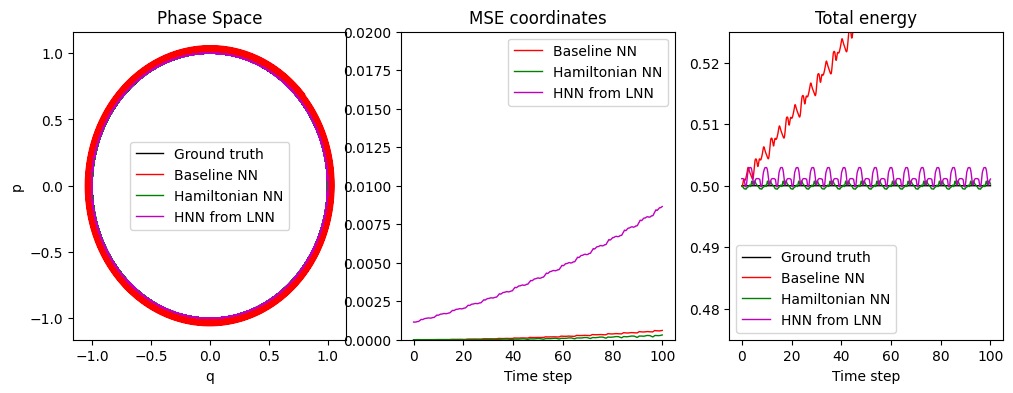

<Figure size 640x480 with 0 Axes>

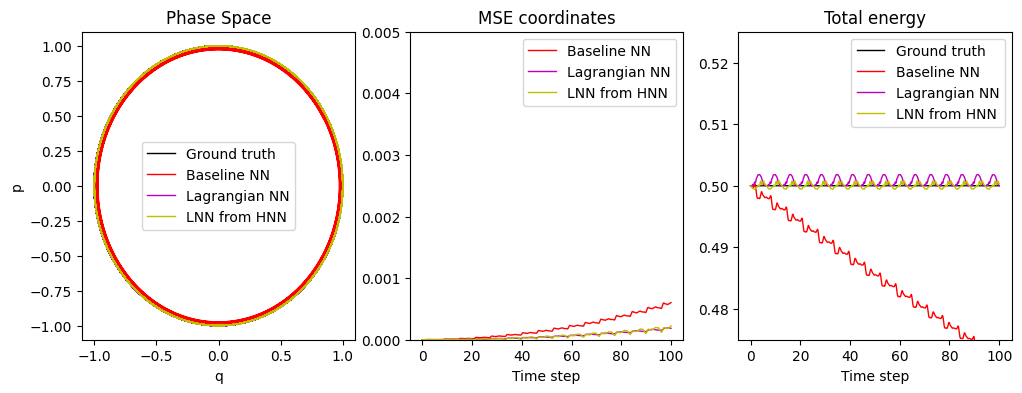

<Figure size 640x480 with 0 Axes>

In [346]:
#for HNN
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.plot(q_true, p_true, 'k-', label='Ground truth', lw=1.0) 
plt.plot(q_bnn_h, p_bnn_h, 'r-', label='Baseline NN', lw=1.0) 
plt.plot(q_hnn, p_hnn, 'g-', label='Hamiltonian NN', lw=1.0)
plt.plot(q_hnn_from_lnn, p_hnn_from_lnn, 'm-', label='HNN from LNN', lw=1.0)  
plt.title(f'Phase Space') 
plt.xlabel('q') 
plt.ylabel('p') 
plt.legend() 

plt.subplot(1,3,2)
plt.ylim(0, 0.02)
#plt.xlim(0, 30)
plt.plot(t_true, mse_bnn_h, 'r-', label='Baseline NN', lw=1.0) 
plt.plot(t_true, mse_hnn, 'g-', label='Hamiltonian NN', lw=1.0)
plt.plot(t_true, mse_hnn_from_lnn, 'm-', label='HNN from LNN', lw=1.0) 
plt.title(f'MSE coordinates') 
plt.xlabel('Time step') 
plt.legend() 

#HNNにそれぞれのデータを入れている
'''
参考にする
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_model(torch.Tensor(true_x))[1].detach().numpy().squeeze()
base_hq = hnn_model(torch.Tensor(base_x))[1].detach().numpy().squeeze()
hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
'''

'''
plt.subplot(1,4,3)
plt.plot(t_true, HNN, 'g-', label='Hamiltonian NN', lw=1.0)
plt.ylim(0, 10)
plt.title(f'Total HNN-conserved quantity')
plt.xlabel('Time step')
plt.legend()
'''

plt.subplot(1,3,3)
plt.plot(t_true, total_energy_truth, 'k-', label='Ground truth', lw=1.0) 
plt.plot(t_true, total_energy_bnn_h, 'r-', label='Baseline NN', lw=1.0) 
plt.plot(t_true, total_energy_hnn, 'g-', label='Hamiltonian NN', lw=1.0)
plt.plot(t_true, total_energy_hnn_from_lnn, 'm-', label='HNN from LNN', lw=1.0) 
plt.title(f'Total energy')
plt.xlabel('Time step')
plt.ylim(0.475, 0.525)
plt.legend()
plt.show()
plt.tight_layout()
plt.show()

#for LNN
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.plot(q_true, p_true, 'k-', label='Ground truth', lw=1.0) 
plt.plot(q_bnn_l, p_bnn_l, 'r-', label='Baseline NN', lw=1.0) 
plt.plot(q_lnn, p_lnn, 'm-', label='Lagrangian NN', lw=1.0)  
plt.plot(q_lnn_from_hnn, p_lnn_from_hnn, 'y-', label='LNN from HNN', lw=1.0)  
plt.title(f'Phase Space') 
plt.xlabel('q') 
plt.ylabel('p') 
plt.legend() 

plt.subplot(1,3,2)
plt.ylim(0, 0.005)
plt.plot(t_true, mse_bnn_h, 'r-', label='Baseline NN', lw=1.0) 
plt.plot(t_true, mse_lnn, 'm-', label='Lagrangian NN', lw=1.0)  
plt.plot(t_true, mse_lnn_from_hnn, 'y-', label='LNN from HNN', lw=1.0) 
plt.title(f'MSE coordinates') 
plt.xlabel('Time step') 
plt.legend() 

plt.subplot(1,3,3)
plt.plot(t_true, total_energy_truth, 'k-', label='Ground truth', lw=1.0) 
plt.plot(t_true, total_energy_bnn_l, 'r-', label='Baseline NN', lw=1.0) 
plt.plot(t_true, total_energy_lnn, 'm-', label='Lagrangian NN', lw=1.0)  
plt.plot(t_true, total_energy_lnn_from_hnn, 'y-', label='LNN from HNN', lw=1.0)  
plt.title(f'Total energy')
plt.xlabel('Time step')
plt.ylim(0.475, 0.525)
plt.legend()
plt.show()
plt.tight_layout()
plt.show()